<a href="https://colab.research.google.com/github/wangleiphy/ml4p/blob/main/projects/quantum_dot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Authors: [Yangfan Li](mailto:liyangfan@iphy.ac.cn) 、 [Lu Zhao](mailto:zhaolu@iphy.ac.cn) and [Lei Wang](mailto:wanglei@iphy.ac.cn), Insititute of Physics, Chinese Academy of Sciences.

We will use [Jax](https://jax.readthedocs.io/en/latest/) for this tutorial. [Why Jax?](https://www.assemblyai.com/blog/why-you-should-or-shouldnt-be-using-jax-in-2022/)

Building networks using TRANSFORMER.

In [ ]:
# some necessary packages
!pip install -q dm-haiku  # neural network library
!pip install -q optax   # optimization library

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.1/352.1 kB 9.4 MB/s eta 0:00:00


In [ ]:
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import numpy as np
import haiku as hk
import optax
import networkx as nx
import matplotlib.pyplot as plt 
from IPython import display


In [ ]:
!nvidia-smi
jax.devices()

Fri Apr 28 12:50:01 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

[StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0)]

## Hamiltonian of classical Coulomb gas

We'd like to study thermodynamic property of the classical Coulomb gas, whose Hamiltonian reads

$$H= \sum_{i<j} \frac{1}{|\boldsymbol{x}_i - \boldsymbol{x}_j|} + \sum_i  \boldsymbol{x}_i^2 . $$
The second term is a harmonic trapping potential. It makes our story easier (no need to consider periodic bondary condition or Ewald sum for long range interaction.)

The way to go is to minimize the variationial free energy with respect to a variational probability density $p(\boldsymbol{x})$

$$\mathcal{L} = \mathbb{E}_{\boldsymbol{x} \sim p(\boldsymbol{x})} \left [\frac{1}{\beta}\ln p(\boldsymbol{x}) +  H(\boldsymbol{x}) \right] \ge -\frac{1}{\beta} \ln Z, $$ 
where $Z = \int d \boldsymbol{x} e^{-\beta H}$ and $\beta$ is the inverse temperature. The equality holds when $p(\boldsymbol{x}) = e^{-\beta H}/Z$, i.e., we achieve the exact solution. 

First thing first, here is the energy function

In [ ]:
def energy_fn(x, n, dim):
    i, j = np.triu_indices(n, k=1)
    r_ee = jnp.linalg.norm((jnp.reshape(x, (n, 1, dim)) - jnp.reshape(x, (1, n, dim)))[i,j], axis=-1)
    v_ee = jnp.sum(1/r_ee)
    #temp = jnp.reshape(x, (n, dim))
    #temp1 = temp[:,0]
    #temp2 = temp[:,1]
    #potential = jnp.multiply(temp1**2, temp2**2)
    return jnp.sum(x**2) + v_ee

In [ ]:
x = jnp.arange(10)
#print(jnp.reshape(x, (5, 1, 2)))
#print(jnp.reshape(x, (1, 5, 2)))
#jnp.reshape(x, (5, 1, 2)) - jnp.reshape(x, (1, 5, 2))
x1 = jnp.reshape(x, (5, 2))
print(x1)
x2 = jnp.reshape(x1, (10,))
x2
#print(jnp.eye(3))
#jnp.sin(jnp.reshape(x, (5, 2)))
#x2 = jnp.vstack((x,x))
#print((jnp.transpose(x2)).flatten())
#jnp.diag(x)

[[0 1]
 [2 3]
 [4 5]
 [6 7]
 [8 9]]


Array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

## Probablistic generative model

The probablistic model we are going to use is the flow model which does change of variable. 

$$
p(x) = p(z) \left|\frac{\partial z }{\partial x}\right|, 
$$
which means $$
\ln p(x) = \ln p(z) - \ln \left|\frac{\partial x  }{\partial z}\right|
$$



In [ ]:
def make_transformer(key, n, dim, num_layers, hidden_sizes, num_heads, key_size):
   
    # read this to understand why we need these lines https://sjmielke.com/jax-purify.htm
    @hk.without_apply_rng
    @hk.transform
    def transformer_network(z): 
        # first apply MLP
        z = hk.nets.MLP(hidden_sizes + [n*dim], 
                           activation=jax.nn.elu, 
                           w_init=hk.initializers.TruncatedNormal(0.1), 
                           b_init=hk.initializers.TruncatedNormal(1.0),
                           )(z)

        z = jnp.reshape(z, (n, dim))
        # transformer block
        model_size = dim # transform from z into x
        #mask = jnp.tril(np.ones((1, n, n))) # mask for the attention matrix 
        mask = None

        initializer = hk.initializers.TruncatedNormal(0.2)
        h = hk.Linear(model_size, w_init=initializer)(z)
        for _ in range(num_layers):
            # https://github.com/deepmind/dm-haiku/blob/main/haiku/_src/attention.py 
            attn_block = hk.MultiHeadAttention(num_heads=num_heads, 
                               key_size=key_size, 
                               model_size=model_size,
                               w_init = initializer
                                )   
            h = attn_block(h, h, h, mask) + h

            dense_block = hk.Sequential([hk.Linear(4 * model_size, w_init=initializer),
                                         jax.nn.elu,
                                         hk.Linear(model_size, w_init=initializer)]
                                         )
            h = dense_block(h) + h 
        
        z = jnp.reshape(h, (n*dim, ))
        
        return z    
    
    z = jax.random.normal(key, (n*dim, ))
    params = transformer_network.init(key, z)
    return params, transformer_network.apply

def make_flow(network):
    def flow(params, z):
        x = network(params, z)
        jac = jax.jacfwd(network,argnums=1)(params, z)
        _, logabsdet = jnp.linalg.slogdet(jac)
        return x, jnp.sum(jax.scipy.stats.norm.logpdf(z)) - logabsdet

    return flow


Next, we initialize and test the transformer network

In [ ]:
n = 20
dim = 2
hidden_sizes = [64, 64]
num_layers = 1
num_heads = 4
key_size = 4

key = jax.random.PRNGKey(42)
params, transformer = make_transformer(key, n, dim, num_layers, hidden_sizes, num_heads, key_size)

In [ ]:
from jax.flatten_util import ravel_pytree
ravel_pytree(params)[0].size # number of parameters in the model

9610

In [ ]:
z = jax.random.normal(key, (n*dim, ))
print(transformer(params, z).shape)
transformer(params, z)

(40,)


Array([ 0.0271838 , -0.12439852, -0.07430636,  0.35027998,  0.03020363,
        0.00927263, -0.06514273,  0.05571896, -0.01523969, -0.04799597,
       -0.06754414,  0.27107848,  0.05023182, -0.07374201, -0.02452326,
        0.05677331, -0.04052795,  0.1887415 ,  0.06323421, -0.13258928,
       -0.00629097,  0.05591404, -0.02649183,  0.03721338, -0.06262953,
        0.15103812, -0.03800749,  0.14007392,  0.03586713, -0.15017703,
        0.01256557,  0.02296924,  0.02162184,  0.08543551,  0.0320913 ,
       -0.05620139, -0.03382346,  0.07390916,  0.0298225 , -0.09298803],      dtype=float64)

## Loss function

Gradient of the objective function is

$$\nabla \mathcal{L} = \mathbb{E}_{\boldsymbol{z} \sim \mathcal{N}(\boldsymbol{z})} \left[   \nabla f(g( \boldsymbol{z}) )\right],$$ 
where $f (\boldsymbol{x}) =\frac{1}{\beta}\ln p(\boldsymbol{x}) +  H(\boldsymbol{x})$. This is known as the Reparametrization gradient estimator. See https://arxiv.org/abs/1906.10652 for more details. 


In [ ]:
def make_loss(batch_flow, n, dim, beta):

    batch_energy = jax.vmap(energy_fn, (0, None, None), 0)

    def loss(params, z):
        x, logp = batch_flow(params, z)
        energy = batch_energy(x, n, dim)
        f = logp/beta + energy
        return jnp.mean(f), (jnp.std(f)/jnp.sqrt(x.shape[0]), x)
    return loss

### Initializing

Now we are ready to initialize the network:

In [ ]:
batchsize = 3200
beta = 10.0

flow = make_flow(transformer)
batch_flow = jax.vmap(flow, (None, 0), (0, 0))
loss = make_loss(batch_flow, n, dim, beta)
value_and_grad = jax.value_and_grad(loss, has_aux=True)

X is the output of the neural network. The shape of x should be equal to z. The shape of logp should be equal to batchsize:


In [ ]:
z = jax.random.normal(key, (n*dim, ))
x, logp = flow(params, z)
print(x)
print(logp)
#x, logp = batch_flow(params, z)
#x.shape, logp.shape
#value, grad = value_and_grad(params, z)
#print(grad)

[ 0.0271838  -0.12439852 -0.07430636  0.35027998  0.03020363  0.00927263
 -0.06514273  0.05571896 -0.01523969 -0.04799597 -0.06754414  0.27107848
  0.05023182 -0.07374201 -0.02452326  0.05677331 -0.04052795  0.1887415
  0.06323421 -0.13258928 -0.00629097  0.05591404 -0.02649183  0.03721338
 -0.06262953  0.15103812 -0.03800749  0.14007392  0.03586713 -0.15017703
  0.01256557  0.02296924  0.02162184  0.08543551  0.0320913  -0.05620139
 -0.03382346  0.07390916  0.0298225  -0.09298803]
177.31467585881663


In [ ]:
z = jax.random.normal(key, (batchsize, n*dim))
x, logp = batch_flow(params, z)
x.shape, logp.shape
#value, grad = value_and_grad(params, z)
#print(grad)

((2500, 40), (2500,))

We use optax as optimizer to train this neural network.

In [ ]:
optimizer = optax.adam(2e-4)
#optimizer = optax.amsgrad(1e-3)
opt_state = optimizer.init(params)

## Optimization

Here is the training loop. During training we monitor the density and loss histroy. 

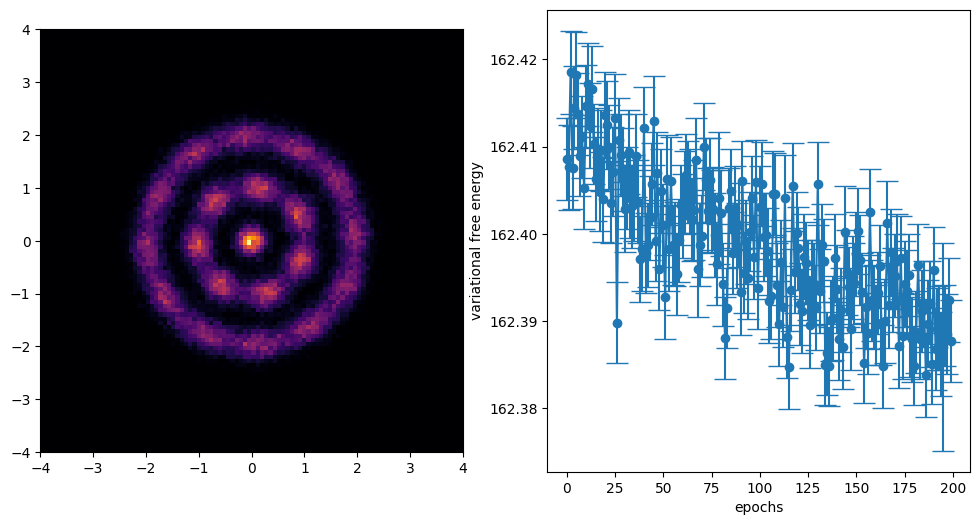

[Array(162.38768475, dtype=float64), Array(0.00471511, dtype=float64)]


In [ ]:
@jax.jit
def step(key, params, opt_state):
    z = jax.random.normal(key, (batchsize, n*dim))
    '''
    key1, key2 = jax.random.split(key, 2)
    r = jax.random.maxwell(key1, (batchsize, n))
    theta = jax.random.uniform(key2, (batchsize, n), minval=0.0, maxval=2*jnp.pi)
    ctheta = jnp.cos(theta)
    stheta = jnp.sin(theta)
    x = jnp.multiply(r, ctheta)
    y = jnp.multiply(r, stheta)
    x = x.flatten()
    y = y.flatten()
    z = jnp.transpose(jnp.vstack((x,y))).flatten()
    z = jnp.reshape(z, (batchsize, n*dim))
    '''
    value, grad = value_and_grad(params, z)
    updates, opt_state = optimizer.update(grad, opt_state)
    params = optax.apply_updates(params, updates)
    return value, params, opt_state

loss_history = []
for i in range(200):
    key, subkey = jax.random.split(key)
    value,  params, opt_state = step(subkey, params, opt_state)
    f_mean, (f_err, x) = value
    loss_history.append([f_mean, f_err])
    print(i, f_mean)

    x = jnp.reshape(x, (batchsize*n, dim)) 

    display.clear_output(wait=True)

    fig = plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    H, xedges, yedges = np.histogram2d(x[:, 0], x[:, 1], 
                                       bins=100, 
                                       range=((-4, 4), (-4, 4)),
                        density=True)
    plt.imshow(H, interpolation="nearest", 
               extent=(xedges[0], xedges[-1], yedges[0], yedges[-1]),
               cmap="inferno")

    plt.xlim([-4, 4])
    plt.ylim([-4, 4])

    plt.subplot(1, 2, 2)
    y = np.reshape(np.array(loss_history), (-1, 2))
    plt.errorbar(np.arange(i+1), y[:, 0], yerr=y[:, 1], marker='o', capsize=8)
    plt.xlabel('epochs')
    plt.ylabel('variational free energy')
    plt.pause(0.01)
print(loss_history[-1])

Let's look at energy

In [ ]:
print(jax.vmap(energy_fn, (0, None, None), 0)(x.reshape(batchsize, n, dim), n, dim).mean())
z = jax.random.normal(key, (batchsize, n*dim))
FF, _ = loss(params, z)
print(FF)
xxx, logp = batch_flow(params, z)
print(jnp.mean(logp/beta))

160.8014340037277
162.39511898340297
1.580775825354427


- How does the results connect to the our previous [Monte Carlo calculation](https://github.com/wangleiphy/ml4p/blob/main/materials/2_handson/jax.ipynb) ? 
- How do you make sure the variational free energy is low enough ? 
- Could you explain the training dynamics ? What did the network learn in the early and late stage of the training ? 

A few things to improve from this mininist implementation: 
* We have not ensured the transformation $z↔x$ is actually invertible. How to ensure that?
* It seems the training breaks rotational invariance. But it shouldn't. How to incorporate that into the model design ? 

* How about the permutation invariance of the probability $p(\mathcal{P}\boldsymbol{x}) = p(\boldsymbol{x})$ ?